## Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.dask

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn import metrics

import scipy

import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, SSHCluster
import dask.distributed

import dask_ml
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import LabelEncoder

import xgboost as xgb

import mpl_scatter_density
import matplotlib.colors as colors

import csv

## Setting up the cluster

In [ ]:
#cluster.close()

In [ ]:
cluster = SSHCluster(["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": 4,
                                    "nthreads": 1}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                    )

2023-06-27 07:15:22,559 - distributed.deploy.ssh - INFO - 2023-06-27 07:15:22,557 - distributed.scheduler - INFO - State start
2023-06-27 07:15:22,568 - distributed.deploy.ssh - INFO - 2023-06-27 07:15:22,567 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-27 07:15:23,523 - distributed.deploy.ssh - INFO - 2023-06-27 07:15:23,522 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:36133'
2023-06-27 07:15:23,529 - distributed.deploy.ssh - INFO - 2023-06-27 07:15:23,528 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:37021'
2023-06-27 07:15:23,533 - distributed.deploy.ssh - INFO - 2023-06-27 07:15:23,532 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:40173'
2023-06-27 07:15:23,536 - distributed.deploy.ssh - INFO - 2023-06-27 07:15:23,536 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:39495'
2023-06-27 07:15:23,645 - distributed.deploy.ssh - INFO - 2023-06-27

In [ ]:
client=Client(cluster)

/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/client.py:1388: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+------------------+
| Package | Client | Scheduler | Workers          |
+---------+--------+-----------+------------------+
| tornado | 6.3.2  | 6.3.2     | {'6.2', '6.3.2'} |
+---------+--------+-----------+------------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [ ]:
client

<Client: 'tcp://10.67.22.140:8786' processes=20 threads=20, memory=38.78 GiB>

## Data

In [ ]:
#defin the value of q to drop
q_drop = 0.2

#import data
bhbh = dd.read_parquet('/home/ubuntu/data/bag_all_dataset_with_no_kick/*')

#Masking on the data
bhbh = bhbh[bhbh['q'] > q_drop] #dropping the value of q under q_drop
#bhbh = bhbh[ bhbh['No_Kick'] == 2] #taking only the binaries without kick

## Discretizing and introducing labels

In [ ]:
#add column label
n_bins = 100
# Define the edges between bins
counts, bin_edges = da.histogram(bhbh.q.values, bins=n_bins, range=(q_drop,1.0))

# pd.cut each column, with each bin closed on left and open on right
bhbh['label'] = bhbh['q'].map_partitions(pd.cut, bin_edges, right=True, labels=False, include_lowest=False)

## Splitting the data in train and set

In [ ]:
bhbh_train, bhbh_test = train_test_split(bhbh, train_size=0.7, shuffle=True)

bhbh_train = bhbh_train.reset_index(drop=True) # just for simplicity sake in the final visualisation
bhbh_test = bhbh_test.reset_index(drop=True)   # and so that we don't mess up later when checking the results

#Repartition for xgboost
bhbh_train = bhbh_train#.repartition(240)

## Sample weigths

In [ ]:
countings = bhbh_train['label'].to_frame().groupby('label').size().compute()
total_counts = countings.sum()

#Assign to a new column
def assign_weight(i):
    return np.log(total_counts/(n_bins*countings[i])+1) 

bhbh_train['weight'] = bhbh_train['label'].map(assign_weight)

## Plot of weights respect to labels

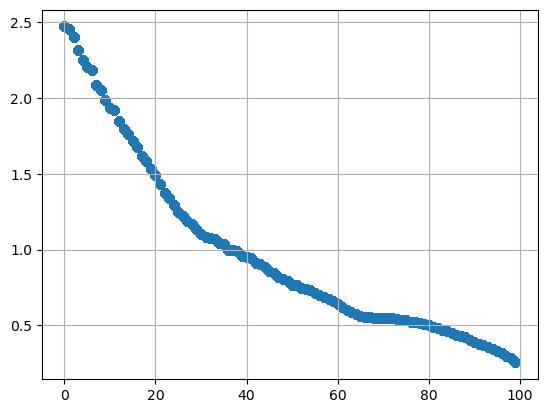

In [ ]:
plt.scatter(bhbh_train['label'], bhbh_train['weight'])
plt.grid()
plt.show()

## Rename of useful columns

In [ ]:
#training
weights = bhbh_train['weight']
labels = bhbh_train['label']
features = bhbh_train[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]

#test
features_test = bhbh_test[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]
label_test = bhbh_test['label']

## Consistency of partitions

In [ ]:
print('Consistency check')
print('features:', type(features), features.npartitions)

print('label', type(labels), labels.npartitions)
print('weight', type(weights), weights.npartitions)

Consistency check
features: <class 'dask.dataframe.core.DataFrame'> 1800
label <class 'dask.dataframe.core.Series'> 1800
weight <class 'dask.dataframe.core.Series'> 1800


## XGBoost

In [ ]:
#parameters
max_depth = 0
learning_rate = 0.2
grow_policy = 'lossguide'
n_estimators = 5
max_leaves = 400

param = {'objective': 'multi:softprob',
         'tree_method': 'hist', 
         'n_estimators' : n_estimators, #equivalent to num_boost_round, lets keep it in params
         'grow_policy' : grow_policy, 
         'max_depth' : max_depth,
         'learning_rate' : learning_rate,
         'max_leaves' : max_leaves,
         'num_class': n_bins,
         'n_jobs' : -1,
        }

In [ ]:
dtrain = xgb.dask.DaskDMatrix(client, features, label=labels, weight=weights)
# dtrain = xgb.dask.DaskDMatrix(client, features, label=labels) #test what happens without weight

In [ ]:
# train XGB
bst = xgb.dask.train(client, param, dtrain, evals=[(dtrain, "train")])

## Prediction on test

In [ ]:
## distributions of the probability of each class for each record

In [ ]:
output_test = xgb.dask.predict(client, bst, features_test).persist() #already a dataframe

In [ ]:
## Predicition of the label with Maximum estimation

In [ ]:
predicted_label = output_test.idxmax(axis=1).persist()

In [ ]:
## Computing the true labels and the predicted

In [ ]:
Y_test = label_test.values.compute()

In [ ]:
Y_predicted = predicted_label.values.compute()

## Scatter Plot with density

In [ ]:
def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap='Reds',
                                 norm=colors.LogNorm(vmin=1, vmax=1000))
    fig.colorbar(density, label='Number of points per pixel')

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


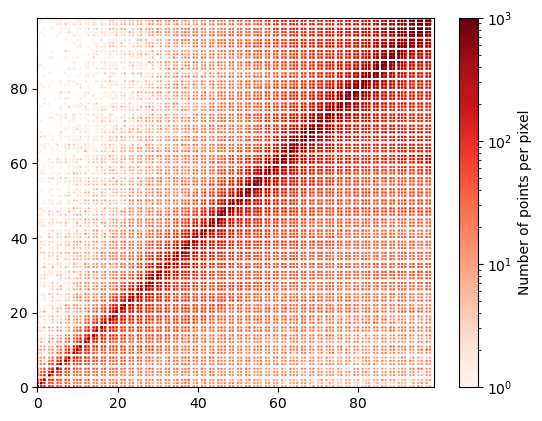

In [ ]:
fig = plt.figure()
using_mpl_scatter_density(fig, Y_test, Y_predicted)
plt.show()

plt.scatter(Y_test, Y_predicted, alpha = 0.1, s = 0.01)

## Histogram of the q distribution

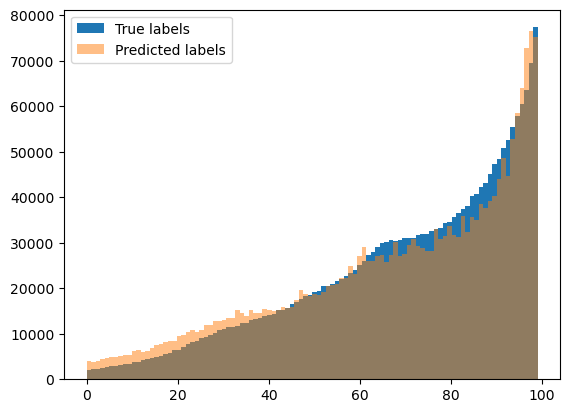

In [ ]:
plt.hist(Y_test, bins=n_bins, label = 'True labels')
plt.hist(Y_predicted, bins=n_bins, alpha=0.5, label='Predicted labels')
plt.legend()

## Kulback-Leibler metrics

In [ ]:
counts_test, _ = np.histogram(Y_test, density=True, bins=n_bins)
counts_predicted, _ = np.histogram(Y_predicted, density=True, bins=n_bins)

In [79]:
KL_div = scipy.stats.entropy(counts_predicted, counts_test)

In [80]:
KL_div

0.010647750256522455

## Histogram of difference of true and prediction

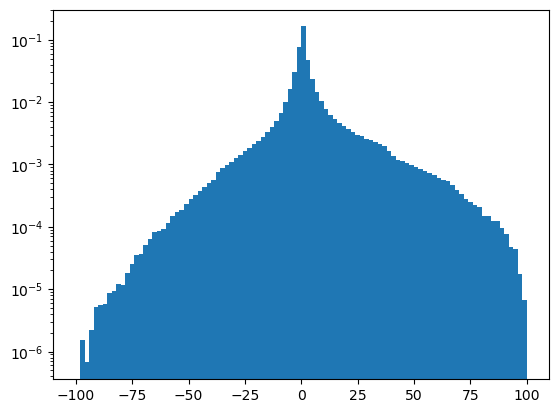

In [82]:
plt.hist(Y_test-Y_predicted, bins=n_bins, density=True, log=True, range=(-n_bins, n_bins))
plt.show()

## Misura della accuracy

In [ ]:
## Defining a prediction accurate if not further from the true of a value of threshold
def accuracy_threshold(Y_test, Y_predicted, threshold = 5):
    out=np.abs(Y_test-Y_predicted)
    mask = out < threshold
    return np.sum(mask)/len(Y_test)

In [ ]:
accuracy_threshold(Y_test, Y_predicted, 13)

0.8286753647440953

In [ ]:
def accuracy_exponential(Y_test, Y_predicted, threshold = 25, tau = 25):
    out = np.exp(-np.abs(Y_test-Y_predicted)/tau)
    out = out[np.abs(Y_test-Y_predicted)<threshold]
    return np.sum(out)/len(Y_test)

In [ ]:
accuracy_exponential(Y_test, Y_predicted)

0.7948668243608339

## Grid Search with For Loops

In [ ]:
dtrain = xgb.dask.DaskDMatrix(client, features, label=labels, weight=weights)
# dtrain = xgb.dask.DaskDMatrix(client, features, label=labels) #test what happens without weight

In [ ]:
#parameters list
max_depth_list = [10]
learning_rate_list = [0.2]
grow_policy = 'lossguide'
n_estimators_list = [5]
max_leave_list = [200, 400]

In [ ]:
#GRID SEARCH

#file in wich to save the results of the grid search
f = open('grid_search_results.csv', 'a')
writer = csv.writer(f)

#writing the head of the file
head = ['max_depth', 'learning_rate', 'n_estimators', 'max_leaves', 'KL_div', 'AT', 'AE']
print('max_depth', 'learning_rate', 'n_estimators', 'max_leaves', 'KL_div', 'AT', 'AE')
writer.writerow(head)

for max_depth in max_depth_list:
    
    for learning_rate in learning_rate_list:
        
        for n_estimators in n_estimators_list:
            
            for max_leaves in max_leave_list:
    
                
            
                
                #list of parameters
                param = {'objective': 'multi:softprob',
                         'tree_method': 'hist', 
                         'n_estimators' : n_estimators, #equivalent to num_boost_round, lets keep it in params
                         'grow_policy' : grow_policy, 
                         'max_depth' : max_depth,
                         'learning_rate' : learning_rate,
                         'max_leaves' : max_leaves,
                         'num_class': n_bins,
                         'n_jobs' : -1,
                        }
                #training the model
                bst = xgb.dask.train(client, param, dtrain, evals=[(dtrain, "train")])
                
                #extracting the predictions
                output_test = xgb.dask.predict(client, bst, features_test).persist() #already a dataframe
                predicted_label = output_test.idxmax(axis=1).persist()
                Y_test = label_test.values.compute()
                Y_predicted = predicted_label.values.compute()
                
                #Kulback-Leibler
                counts_test, _ = np.histogram(Y_test, density=True, bins=n_bins)
                counts_predicted, _ = np.histogram(Y_predicted, density=True, bins=n_bins)
                
                KL_div = scipy.stats.entropy(counts_predicted, counts_test)
                
                #Accuracy threshold
                AT = accuracy_threshold(Y_test, Y_predicted, 15)
                
                #Accuracy exponential
                AE = accuracy_exponential(Y_test, Y_predicted)
                
                row= [max_depth, learning_rate, n_estimators, max_leaves, KL_div, AT, AE] 
                print(max_depth, learning_rate, n_estimators, max_leaves, KL_div, AT, AE)
                writer.writerow(row)
                
                
f.close()              


max_depth learning_rate n_estimators max_leaves KL_div AT AE
10 0.2 5 200 0.02435401125128044 0.8012450347992615 0.7414482979744199
10 0.2 5 400 0.02278590575592224 0.8194214208143709 0.7585389813537317


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.dask

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn import metrics

import scipy

import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, SSHCluster
import dask.distributed

import dask_ml
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import LabelEncoder

import xgboost as xgb

import mpl_scatter_density
import matplotlib.colors as colors

import csv

## Setting up the cluster

In [ ]:
#cluster.close()

In [ ]:
cluster = SSHCluster(["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": 4,
                                    "nthreads": 1}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                    )

2023-06-27 07:15:22,559 - distributed.deploy.ssh - INFO - 2023-06-27 07:15:22,557 - distributed.scheduler - INFO - State start
2023-06-27 07:15:22,568 - distributed.deploy.ssh - INFO - 2023-06-27 07:15:22,567 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-27 07:15:23,523 - distributed.deploy.ssh - INFO - 2023-06-27 07:15:23,522 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:36133'
2023-06-27 07:15:23,529 - distributed.deploy.ssh - INFO - 2023-06-27 07:15:23,528 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:37021'
2023-06-27 07:15:23,533 - distributed.deploy.ssh - INFO - 2023-06-27 07:15:23,532 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:40173'
2023-06-27 07:15:23,536 - distributed.deploy.ssh - INFO - 2023-06-27 07:15:23,536 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:39495'
2023-06-27 07:15:23,645 - distributed.deploy.ssh - INFO - 2023-06-27

In [ ]:
client=Client(cluster)

/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/client.py:1388: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+------------------+
| Package | Client | Scheduler | Workers          |
+---------+--------+-----------+------------------+
| tornado | 6.3.2  | 6.3.2     | {'6.2', '6.3.2'} |
+---------+--------+-----------+------------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [ ]:
client

<Client: 'tcp://10.67.22.140:8786' processes=20 threads=20, memory=38.78 GiB>

## Data

In [ ]:
#defin the value of q to drop
q_drop = 0.2

#import data
bhbh = dd.read_parquet('/home/ubuntu/data/bag_all_dataset_with_no_kick/*')

#Masking on the data
bhbh = bhbh[bhbh['q'] > q_drop] #dropping the value of q under q_drop
#bhbh = bhbh[ bhbh['No_Kick'] == 2] #taking only the binaries without kick

## Discretizing and introducing labels

In [ ]:
#add column label
n_bins = 100
# Define the edges between bins
counts, bin_edges = da.histogram(bhbh.q.values, bins=n_bins, range=(q_drop,1.0))

# pd.cut each column, with each bin closed on left and open on right
bhbh['label'] = bhbh['q'].map_partitions(pd.cut, bin_edges, right=True, labels=False, include_lowest=False)

## Splitting the data in train and set

In [ ]:
bhbh_train, bhbh_test = train_test_split(bhbh, train_size=0.7, shuffle=True)

bhbh_train = bhbh_train.reset_index(drop=True) # just for simplicity sake in the final visualisation
bhbh_test = bhbh_test.reset_index(drop=True)   # and so that we don't mess up later when checking the results

#Repartition for xgboost
bhbh_train = bhbh_train#.repartition(240)

## Sample weigths

In [ ]:
countings = bhbh_train['label'].to_frame().groupby('label').size().compute()
total_counts = countings.sum()

#Assign to a new column
def assign_weight(i):
    return np.log(total_counts/(n_bins*countings[i])+1) 

bhbh_train['weight'] = bhbh_train['label'].map(assign_weight)

## Plot of weights respect to labels

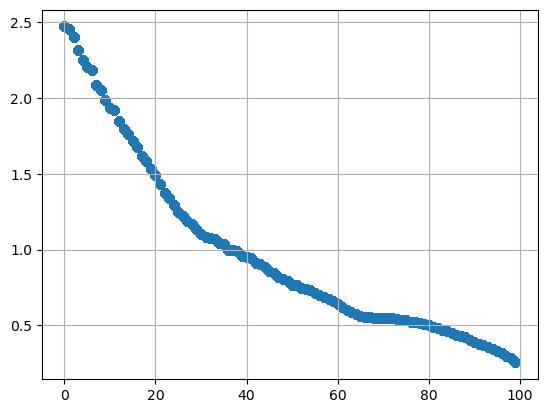

In [ ]:
plt.scatter(bhbh_train['label'], bhbh_train['weight'])
plt.grid()
plt.show()

## Rename of useful columns

In [ ]:
#training
weights = bhbh_train['weight']
labels = bhbh_train['label']
features = bhbh_train[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]

#test
features_test = bhbh_test[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]
label_test = bhbh_test['label']

## Consistency of partitions

In [ ]:
print('Consistency check')
print('features:', type(features), features.npartitions)

print('label', type(labels), labels.npartitions)
print('weight', type(weights), weights.npartitions)

Consistency check
features: <class 'dask.dataframe.core.DataFrame'> 1800
label <class 'dask.dataframe.core.Series'> 1800
weight <class 'dask.dataframe.core.Series'> 1800


## XGBoost

In [ ]:
#parameters
max_depth = 0
learning_rate = 0.2
grow_policy = 'lossguide'
n_estimators = 5
max_leaves = 400

param = {'objective': 'multi:softprob',
         'tree_method': 'hist', 
         'n_estimators' : n_estimators, #equivalent to num_boost_round, lets keep it in params
         'grow_policy' : grow_policy, 
         'max_depth' : max_depth,
         'learning_rate' : learning_rate,
         'max_leaves' : max_leaves,
         'num_class': n_bins,
         'n_jobs' : -1,
        }

In [ ]:
dtrain = xgb.dask.DaskDMatrix(client, features, label=labels, weight=weights)
# dtrain = xgb.dask.DaskDMatrix(client, features, label=labels) #test what happens without weight

In [ ]:
# train XGB
bst = xgb.dask.train(client, param, dtrain, evals=[(dtrain, "train")])

## Prediction on test

In [ ]:
## distributions of the probability of each class for each record

In [ ]:
output_test = xgb.dask.predict(client, bst, features_test).persist() #already a dataframe

In [ ]:
## Predicition of the label with Maximum estimation

In [ ]:
predicted_label = output_test.idxmax(axis=1).persist()

In [ ]:
## Computing the true labels and the predicted

In [ ]:
Y_test = label_test.values.compute()

In [ ]:
Y_predicted = predicted_label.values.compute()

## Scatter Plot with density

In [ ]:
def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap='Reds',
                                 norm=colors.LogNorm(vmin=1, vmax=1000))
    fig.colorbar(density, label='Number of points per pixel')

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


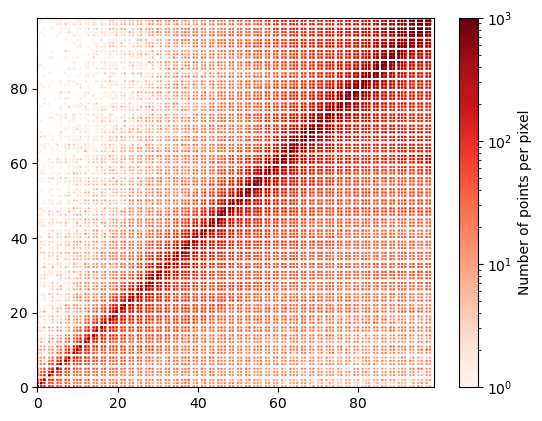

In [ ]:
fig = plt.figure()
using_mpl_scatter_density(fig, Y_test, Y_predicted)
plt.show()

plt.scatter(Y_test, Y_predicted, alpha = 0.1, s = 0.01)

## Histogram of the q distribution

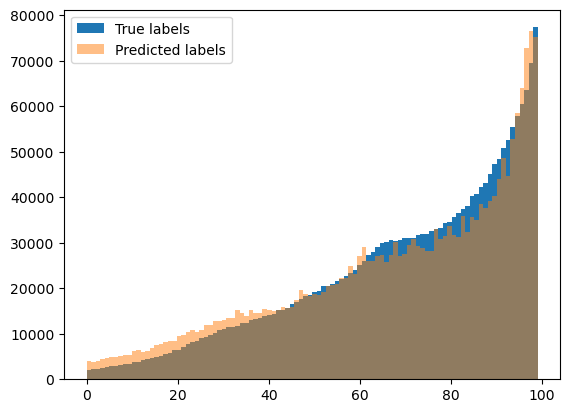

In [ ]:
plt.hist(Y_test, bins=n_bins, label = 'True labels')
plt.hist(Y_predicted, bins=n_bins, alpha=0.5, label='Predicted labels')
plt.legend()

## Kulback-Leibler metrics

In [ ]:
counts_test, _ = np.histogram(Y_test, density=True, bins=n_bins)
counts_predicted, _ = np.histogram(Y_predicted, density=True, bins=n_bins)

In [79]:
KL_div = scipy.stats.entropy(counts_predicted, counts_test)

In [80]:
KL_div

0.010647750256522455

## Histogram of difference of true and prediction

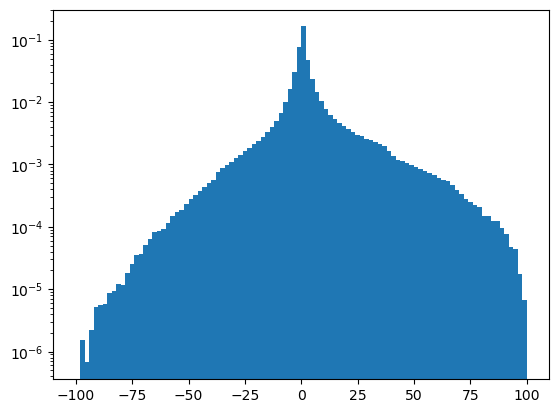

In [82]:
plt.hist(Y_test-Y_predicted, bins=n_bins, density=True, log=True, range=(-n_bins, n_bins))
plt.show()

## Misura della accuracy

In [ ]:
## Defining a prediction accurate if not further from the true of a value of threshold
def accuracy_threshold(Y_test, Y_predicted, threshold = 5):
    out=np.abs(Y_test-Y_predicted)
    mask = out < threshold
    return np.sum(mask)/len(Y_test)

In [ ]:
accuracy_threshold(Y_test, Y_predicted, 13)

0.8286753647440953

In [ ]:
def accuracy_exponential(Y_test, Y_predicted, threshold = 25, tau = 25):
    out = np.exp(-np.abs(Y_test-Y_predicted)/tau)
    out = out[np.abs(Y_test-Y_predicted)<threshold]
    return np.sum(out)/len(Y_test)

In [ ]:
accuracy_exponential(Y_test, Y_predicted)

0.7948668243608339

## Grid Search with For Loops

In [ ]:
dtrain = xgb.dask.DaskDMatrix(client, features, label=labels, weight=weights)
# dtrain = xgb.dask.DaskDMatrix(client, features, label=labels) #test what happens without weight

In [ ]:
#parameters list
max_depth_list = [10]
learning_rate_list = [0.2]
grow_policy = 'lossguide'
n_estimators_list = [5]
max_leave_list = [200, 400]

In [ ]:
#GRID SEARCH

#file in wich to save the results of the grid search
f = open('grid_search_results.csv', 'a')
writer = csv.writer(f)

#writing the head of the file
head = ['max_depth', 'learning_rate', 'n_estimators', 'max_leaves', 'KL_div', 'AT', 'AE']
print('max_depth', 'learning_rate', 'n_estimators', 'max_leaves', 'KL_div', 'AT', 'AE')
writer.writerow(head)

for max_depth in max_depth_list:
    
    for learning_rate in learning_rate_list:
        
        for n_estimators in n_estimators_list:
            
            for max_leaves in max_leave_list:
    
                
            
                
                #list of parameters
                param = {'objective': 'multi:softprob',
                         'tree_method': 'hist', 
                         'n_estimators' : n_estimators, #equivalent to num_boost_round, lets keep it in params
                         'grow_policy' : grow_policy, 
                         'max_depth' : max_depth,
                         'learning_rate' : learning_rate,
                         'max_leaves' : max_leaves,
                         'num_class': n_bins,
                         'n_jobs' : -1,
                        }
                #training the model
                bst = xgb.dask.train(client, param, dtrain, evals=[(dtrain, "train")])
                
                #extracting the predictions
                output_test = xgb.dask.predict(client, bst, features_test).persist() #already a dataframe
                predicted_label = output_test.idxmax(axis=1).persist()
                Y_test = label_test.values.compute()
                Y_predicted = predicted_label.values.compute()
                
                #Kulback-Leibler
                counts_test, _ = np.histogram(Y_test, density=True, bins=n_bins)
                counts_predicted, _ = np.histogram(Y_predicted, density=True, bins=n_bins)
                
                KL_div = scipy.stats.entropy(counts_predicted, counts_test)
                
                #Accuracy threshold
                AT = accuracy_threshold(Y_test, Y_predicted, 15)
                
                #Accuracy exponential
                AE = accuracy_exponential(Y_test, Y_predicted)
                
                row= [max_depth, learning_rate, n_estimators, max_leaves, KL_div, AT, AE] 
                print(max_depth, learning_rate, n_estimators, max_leaves, KL_div, AT, AE)
                writer.writerow(row)
                
                
f.close()              


max_depth learning_rate n_estimators max_leaves KL_div AT AE
10 0.2 5 200 0.02435401125128044 0.8012450347992615 0.7414482979744199
10 0.2 5 400 0.02278590575592224 0.8194214208143709 0.7585389813537317
